***Forest fire detection using deep learning model.***

In [498]:
import rasterio
import os
import numpy as np
from PIL import Image
import cv2
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

**Data Preparation:**

The dataset is prepared by loading remote sensing images and corresponding fire mask labels. Images are read from the specified directory, and their dimensions are adjusted to ensure compatibility with patch-based processing. Each image is divided into smaller patches of a fixed size, which are normalized using the MinMaxScaler. Similarly, mask images are processed by cropping and extracting patches while preserving the spatial correspondence with image patches. The resulting image and mask patches are stored in separate lists for further processing.

In [501]:
minmaxscaler = MinMaxScaler()

In [503]:
dataset_root_folder = "D:/forest_fire"

In [505]:
image_patch_size = 128
label_patch_size=  128

In [507]:
# Initialize datasets as lists
image_dataset = []
mask_dataset = []

# Number of images and labels (you can change this range as per your data)
num_images = 1  # Number of images and labels to process (change as needed)

# Define dataset paths
image_folder = f'{dataset_root_folder}/images'
mask_folder = f'{dataset_root_folder}/labels'

# Initialize the MinMaxScaler for scaling
minmaxscaler = MinMaxScaler()

# Loop through each image and corresponding label
for idx in range(1, num_images + 1): 
    # Process raster image with multiple bands
    image_path = f'{image_folder}/image_{idx}.tif'
    mask_path = f'{mask_folder}/label_{idx}.tif'

    # Process image
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands
        image = np.moveaxis(image, 0, -1)  # Rearrange dimensions to (H, W, Bands)

        # Resize to patchable size
        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size
        # Crop the image to match the patch size
        image = image[:size_y, :size_x, :]

        # Patchify the image
        patched_images = patchify(image, (image_patch_size, image_patch_size, image.shape[-1]), step=image_patch_size)

        # Loop through each patch
        for i in range(patched_images.shape[0]):
            for j in range(patched_images.shape[1]):
                individual_patched_image = patched_images[i, j, :, :]
                individual_patched_image = individual_patched_image[0]  # Remove unnecessary extra dimension

                # Normalize the image patches using MinMaxScaler
                individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)

                # Append the patch to the image dataset list
                image_dataset.append(individual_patched_image)

    # Process corresponding mask in GeoTIFF format
    with rasterio.open(mask_path) as src:
        mask = src.read(1)  # Read only the first band (assuming mask is single-band)

        # Resize to patchable size
        size_x = (mask.shape[1] // image_patch_size) * image_patch_size
        size_y = (mask.shape[0] // image_patch_size) * image_patch_size
        # Crop the mask to match the patch size
        mask = mask[:size_y, :size_x]

        # Patchify the mask (use (patch_size, patch_size) since mask is 2D)
        patched_masks = patchify(mask, (image_patch_size, image_patch_size), step=image_patch_size)

        # Loop through each mask patch
        for i in range(patched_masks.shape[0]):
            for j in range(patched_masks.shape[1]):
                individual_patched_mask = patched_masks[i, j, :, :]  # Extract 2D mask patch

                # Add an extra dimension to the mask patch to match image patch dimensions (HxWx1)
                individual_patched_mask = np.expand_dims(individual_patched_mask, axis=-1)

                # Append the mask patch to the mask dataset list
                mask_dataset.append(individual_patched_mask)

# Now image_dataset and mask_dataset should have matching dimensions
print(f"Image patch shape: {image_dataset[0].shape}")
print(f"Mask patch shape: {mask_dataset[0].shape}")


Image patch shape: (128, 128, 3)
Mask patch shape: (128, 128, 1)


In [508]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [509]:
print(len(image_dataset))
print(len(mask_dataset))

352
352


The fire mask labels are preprocessed to ensure binary classification. Each mask patch is retrieved and any NaN values are replaced with zero. The pixel values are then binarized, where all nonzero values are converted to 1, representing fire-affected areas, while zero represents non-fire regions.

In [511]:
label = individual_patched_mask

In [516]:
!pip install numpy

In [517]:
labels = []
for label in mask_dataset:
    label = np.nan_to_num(label, nan=0)
    label = np.where(label > 0, 1, 0)
    labels.append(label)

labels = np.array(labels)


In [518]:
MIN_FIRE_PIXELS = 5
FIRE_CLASS_INDEX = 1  # fire is 1, background is 0

# fire pixel count per patch
fire_pixel_counts = np.sum(labels == 1, axis=(1, 2, 3))  # assuming shape: (N, H, W, 1)

# keep patches with at least MIN_FIRE_PIXELS
mask_keep = fire_pixel_counts >= MIN_FIRE_PIXELS
print(f"Keeping {np.sum(mask_keep)} patches out of {len(labels)}")

image_dataset = image_dataset[mask_keep]
labels = labels[mask_keep]


Keeping 232 patches out of 352


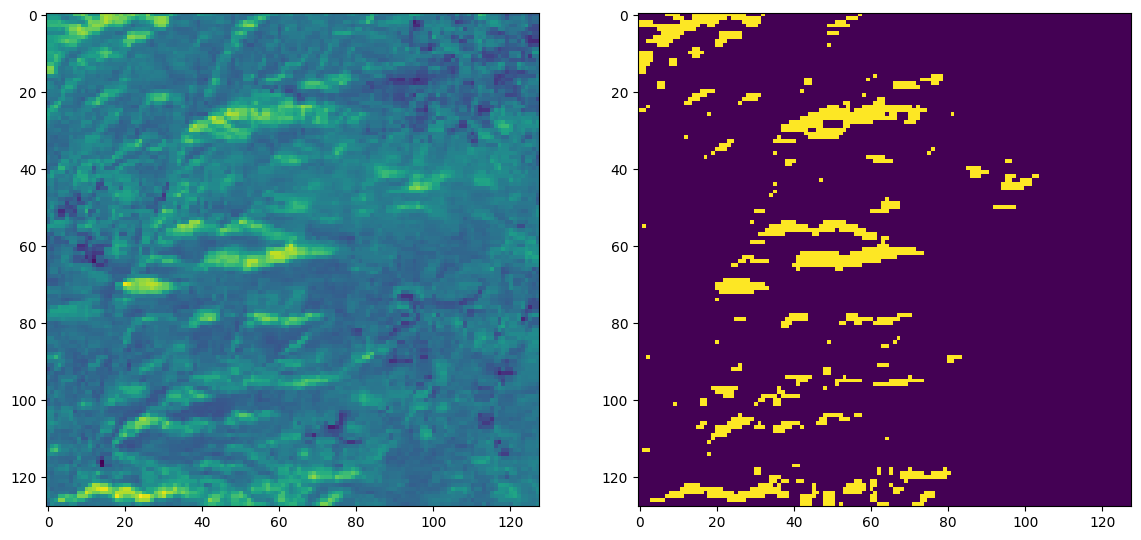

In [519]:
random_image_id = random.randint(0, image_dataset.shape[0] - 1)  # Safe indexing

selected_image = image_dataset[random_image_id]  # Select one image

rgb_image = np.stack(#[selected_image[:, :, 3],  # Red: Band 4
                      #selected_image[:, :, 1],  # Green: Band 3
                      [selected_image[:, :, 0]], axis=-1)  # Blue: Band 2

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(rgb_image)
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])  # Mask
plt.imshow(labels[random_image_id][:, :, 0])  # Labels
plt.show()


In [520]:
total_classes = len(np.unique(labels))
total_classes

2

In [526]:
import numpy as np

# Define color for Fire class (1)
class_fire = '#FF0000'  # Red
class_fire = class_fire.lstrip('#')
class_fire = np.array([int(class_fire[i:i+2], 16) for i in (0, 2, 4)])
print("Fire RGB:", class_fire)

# Define color for No Fire class (0)
class_no_fire = '#00FF00'  # Green
class_no_fire = class_no_fire.lstrip('#')
class_no_fire = np.array([int(class_no_fire[i:i+2], 16) for i in (0, 2, 4)])
print("No Fire RGB:", class_no_fire)

# Optional: map to dictionary for easy lookup
label_colors = {
    0: class_no_fire,  # No Fire
    1: class_fire      # Fire
}

Fire RGB: [255   0   0]
No Fire RGB: [  0 255   0]


The processed binary labels are stored in a NumPy array, and a final check confirms that the labels contain only the expected values (0 and 1).

**Training the data:**

The binary mask labels are transformed into categorical format using one-hot encoding to accommodate multiple class representations. The dataset is then split into training and testing subsets using an 85:15 ratio, ensuring data partitioning for model training and evaluation. The training dataset consists of image patches, while the categorical labels serve as ground truth for classification. A random seed value of 100 is set to maintain reproducibility in the data split.

In [530]:

!pip install tensorflow


In [531]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [532]:
master_training_dataset = image_dataset

In [533]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Step 1: One-hot encode the labels (if not already done)
# labels shape: (N, H, W) → to_categorical → (N, H, W, num_classes)
num_classes = 2
labels_categorical_dataset = to_categorical(labels, num_classes=num_classes)

# Step 2: Confirm shapes match
assert master_training_dataset.shape[0] == labels_categorical_dataset.shape[0], "Mismatched sample count!"

# Step 3: Now split
X_train, X_test, y_train, y_test = train_test_split(
    master_training_dataset,
    labels_categorical_dataset,
    test_size=0.15,
    random_state=100
)


In [534]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(197, 128, 128, 3)
(35, 128, 128, 3)
(197, 128, 128, 2)
(35, 128, 128, 2)


In [535]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]


In [536]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
2


In [537]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [538]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [539]:
from keras import backend as K

A Jaccard coefficient function is defined to evaluate the similarity between predicted and actual fire classification masks. The ground truth (y_true) and predicted mask (y_pred) are flattened into one-dimensional tensors to facilitate element-wise comparison. The intersection, representing correctly predicted fire pixels, is computed as the sum of element-wise multiplications. The union is calculated as the sum of all foreground pixels in both masks, excluding the intersection. The Jaccard coefficient is then derived as the ratio of intersection to union, with a small constant (K.epsilon()) added to prevent division by zero.

In [541]:
def jaccard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return tf.where(tf.equal(union, 0), 0.0, intersection / (union + tf.keras.backend.epsilon()))


A U-Net-based deep learning model is defined to perform fire classification on remote sensing images. The model consists of a contracting path with five convolutional blocks, each containing two convolutional layers with ReLU activation and dropout regularization, followed by max pooling to reduce spatial dimensions. The bottleneck layer, with 256 filters, serves as the deepest part of the network. The expansive path mirrors the contracting path, utilizing transposed convolutions for upsampling and concatenating corresponding encoder features to retain spatial information. The final layer applies a sigmoid or softmax activation function to generate binary or multi-class predictions.

In [543]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def multi_unet_model(n_classes=2, image_height=128, image_width=128, image_channels=3):
    inputs = Input((image_height, image_width, image_channels))

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="sigmoid")(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [544]:
metrics = ["accuracy", jaccard_coef]

In [547]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
2


In [550]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [554]:
model = get_deep_learning_model()

In [555]:
 model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.ini

In [556]:
weights = [0.5, 5.0]

In [557]:
non_fire_pixels = np.sum(labels == 0)
fire_pixels = np.sum(labels == 1)

total_pixels = non_fire_pixels + fire_pixels

fire_percentage = (fire_pixels / total_pixels) * 100
non_fire_percentage = (non_fire_pixels / total_pixels) * 100

print("Total non-fire pixels:", non_fire_pixels)
print("Total fire pixels:", fire_pixels)
print(f"Non-fire pixel percentage: {non_fire_percentage:.2f}%")
print(f"Fire pixel percentage: {fire_percentage:.2f}%")


Total non-fire pixels: 3361280
Total fire pixels: 439808
Non-fire pixel percentage: 88.43%
Fire pixel percentage: 11.57%


In [558]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [559]:
import segmentation_models as sm

In [560]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#jaccard_loss = sm.losses.JaccardLoss()
#total_loss = jaccard_loss + focal_loss

#total_loss = sm.losses.CategoricalFocalLoss(alpha=weights)


In [561]:
import tensorflow as tf

In [562]:
tf.keras.backend.clear_session()

In [563]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [564]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", jaccard_coef])

In [565]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]  

 Total params: 1,941,122 (7.40 MB)

 Trainable params: 1,941,122 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

The training process for the U-Net model is configured with early stopping to prevent overfitting. The EarlyStopping callback monitors validation loss and halts training if no improvement is observed for five consecutive epochs. The best model weights are restored to retain optimal performance. The model is trained using a batch size of eight for a total of 50 epochs, with validation performed on the test dataset. The training process is executed without shuffling to maintain spatial consistency in the image-mask pairs.

In [575]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', # or 'val_accuracy'
                               patience=10,         # Patience for improvement
                               restore_best_weights=True, # Restore the best weights after stopping
                               verbose=1)


In [589]:
model_history = model.fit(X_train, y_train,
                          batch_size=8,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                           callbacks=[early_stopping],
                          shuffle=True)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.8680 - jaccard_coef: 0.4989 - loss: 0.5384 - val_accuracy: 0.9242 - val_jaccard_coef: 0.5595 - val_loss: 0.3614
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8835 - jaccard_coef: 0.6160 - loss: 0.3659 - val_accuracy: 0.9242 - val_jaccard_coef: 0.6662 - val_loss: 0.2545
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8777 - jaccard_coef: 0.7180 - loss: 0.2599 - val_accuracy: 0.9242 - val_jaccard_coef: 0.7314 - val_loss: 0.2014
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.8784 - jaccard_coef: 0.7555 - loss: 0.2172 - val_accuracy: 0.9258 - val_jaccard_coef: 0.7942 - val_loss: 0.1539
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.8889 - jaccard_coef: 0.7856 - loss: 0.1848 - val_accuracy: 0.9641 - val_jaccard_coef: 0.8311 - val_loss: 0.1209
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.9398 - jaccard_coef: 0.8105 - loss: 0.1629 

In [591]:
history_a = model_history
history_a.history

{'accuracy': [0.8736510276794434,
  0.8772115111351013,
  0.8772549033164978,
  0.8780725002288818,
  0.9012194275856018,
  0.945649266242981,
  0.9553634524345398,
  0.9594345688819885,
  0.962744414806366,
  0.9601133465766907],
 'jaccard_coef': [0.554199755191803,
  0.6458261013031006,
  0.7331663370132446,
  0.7608759999275208,
  0.786136269569397,
  0.8284367918968201,
  0.8692833781242371,
  0.8869364261627197,
  0.8917462229728699,
  0.8919132351875305],
 'loss': [0.48564305901527405,
  0.3433781862258911,
  0.2452901005744934,
  0.21376945078372955,
  0.18248935043811798,
  0.14991271495819092,
  0.1137835904955864,
  0.10315237939357758,
  0.09337444603443146,
  0.10035809874534607],
 'val_accuracy': [0.9241629242897034,
  0.9241629242897034,
  0.9241716861724854,
  0.9258004426956177,
  0.9641008377075195,
  0.9566545486450195,
  0.9693498611450195,
  0.970690906047821,
  0.9754377007484436,
  0.9669346213340759],
 'val_jaccard_coef': [0.5594532489776611,
  0.6662393808364868

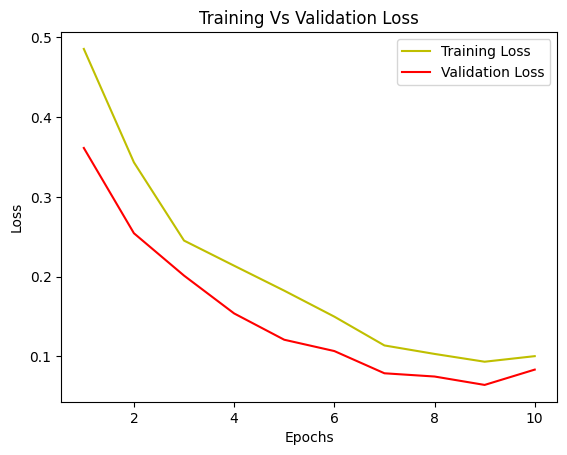

In [593]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

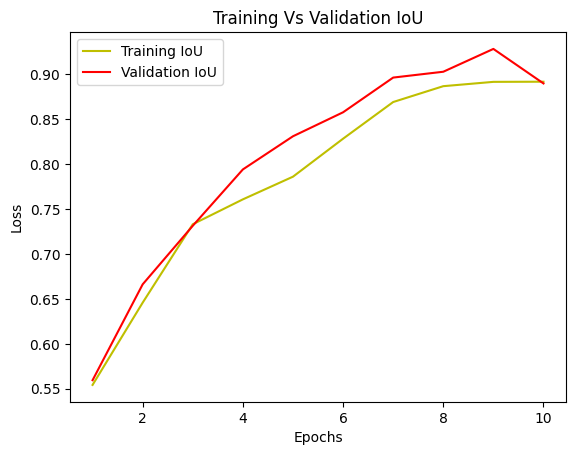

In [595]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [597]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 25}

In [599]:
y_test_argmax = np.argmax(y_test, axis=3)
y_test_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


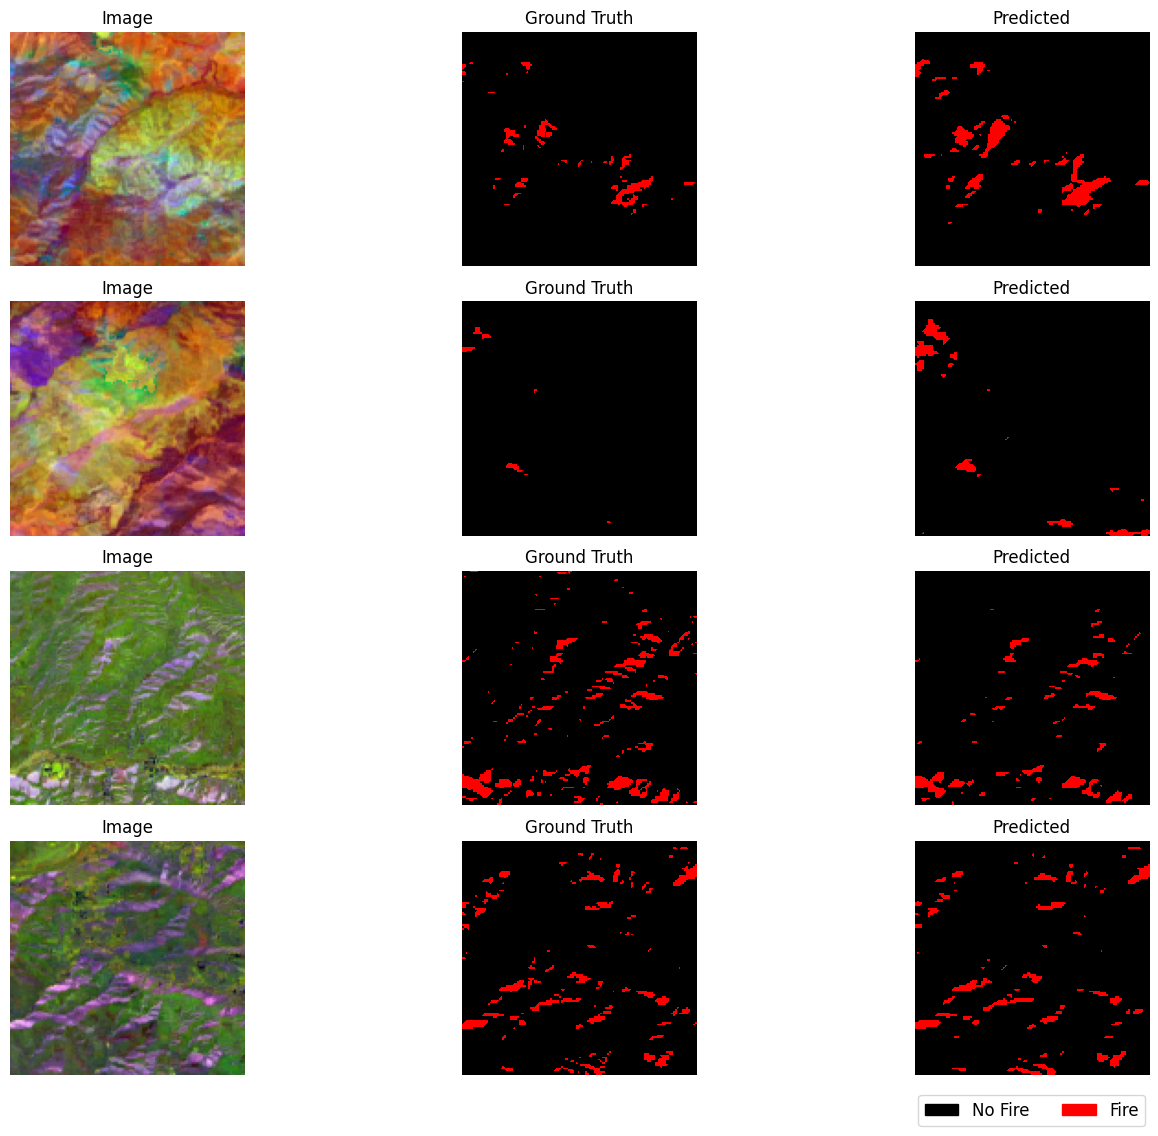

In [601]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Predict
y_pred_probs = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred_probs, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Class names
class_names = ['No Fire', 'Fire']
colors = ['black', 'red']
cmap = ListedColormap(colors)

# Random 4 indices
random_indices = np.random.choice(X_test.shape[0], 4, replace=False)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(random_indices):
    # Image
    plt.subplot(4, 3, i*3 + 1)
    img = X_test[idx]
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        # Normalize for visualization if needed
        norm_img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(norm_img)
    plt.title("Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(y_test_argmax[idx], cmap=cmap, vmin=0, vmax=1)
    plt.title("Ground Truth")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(y_pred_argmax[idx], cmap=cmap, vmin=0, vmax=1)
    plt.title("Predicted")
    plt.axis('off')

# Add legend outside plot
fire_patch = mpatches.Patch(color='red', label='Fire')
no_fire_patch = mpatches.Patch(color='black', label='No Fire')
plt.legend(handles=[no_fire_patch, fire_patch], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make space for legend
plt.show()
